In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pdb
import wandb

import torch
import torch.nn.functional as F
from torch.nn import ReLU, Linear, Sequential, ModuleList
from torch_geometric.nn import global_mean_pool, global_max_pool, global_add_pool

In [9]:
import functions as f

In [10]:
os.environ['WANDB_NOTEBOOK_NAME']="HGAT.ipynb"

In [11]:
# Hypergraph Attention Neural Network
class HGAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, dropout, heads, nbr_classes):
        super(HGAT, self).__init__()
        self.nbr_classes = nbr_classes
        self.convs = ModuleList()
        self.convs.append(f.HypergraphConv(in_channels, hidden_channels, use_attention=True, heads=heads))
        for _ in range(num_layers - 1):
            self.convs.append(f.HypergraphConv(hidden_channels * heads, hidden_channels, use_attention=True, heads=heads))
        self.mlp = Sequential(Linear(hidden_channels * heads, hidden_channels), ReLU(), Linear(hidden_channels, out_channels))
        self.dropout = dropout

    def forward(self, x, edge_index, batch):
        # xs = []
        for conv in self.convs:
            print(edge_index)
            x = conv(x, edge_index)
            x = F.relu(x)
            if self.dropout > 0:
                x = F.dropout(x, p=self.dropout, training=self.training)
                # xs.append(x)
        x = global_mean_pool(x, batch)
        # x = torch.cat(xs, dim=1)
        # x = self.double_mlp(x)
        x = self.mlp(x)
        return x

In [12]:
# Testing the class Raw_to_Hypergraph with one example and saving it
threshold = 0.5
age = False
sex = False
method = 'fourier_cluster'
weight = False

hg_data_path = f'Hypergraphs/{method}/thresh_{threshold}'

root = f'Raw_to_hypergraph/ADNI_T_{threshold}_M_{method}_W{weight}_A{age}_S{sex}_MPTrue'
dataset = f.Raw_to_Hypergraph(root=root, hg_data_path=hg_data_path, method=method, weight=weight, threshold=threshold, age=age, sex=sex)

In [13]:
# Creating the train, validation and test sets
train_loader, valid_loader, test_loader, nbr_classes, y_train = f.create_train_test_valid(dataset)
print(y_train)
print(y_train.size())

Number of training graphs: 137
Number of validation graphs: 20
Number of test graphs: 40
Number of classes: 4
tensor([1., 2., 0., 2., 0., 0., 2., 0., 1., 0., 2., 3., 2., 1., 3., 2., 2., 2.,
        2., 2., 2., 3., 3., 1., 2., 1., 2., 1., 3., 0., 3., 0., 0., 0., 3., 3.,
        2., 0., 3., 2., 0., 3., 1., 1., 1., 0., 2., 3., 0., 3., 3., 2., 2., 2.,
        1., 0., 1., 0., 0., 3., 1., 3., 0., 2., 1., 0., 2., 2., 2., 2., 3., 2.,
        2., 2., 2., 0., 2., 2., 2., 2., 2., 2., 2., 2., 0., 1., 0., 2., 2., 2.,
        2., 2., 0., 2., 2., 0., 3., 2., 2., 1., 2., 0., 2., 2., 2., 2., 0., 2.,
        2., 2., 0., 0., 2., 3., 2., 2., 2., 2., 3., 0., 2., 1., 2., 3., 3., 0.,
        3., 2., 2., 1., 2., 0., 2., 2., 0., 1., 0.])
torch.Size([137])


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [14]:
stratify = True
# Training the model
def train(model, optimizer, criterion, w_decay, threshold, method, train_loader, valid_loader, parameters, test_loader=False, testing=False, n_epochs=100):
    test_loader = test_loader
    testing = testing
    n_epochs = n_epochs

    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    max_valid_accuracy = 0
    test_accuracy = 0

    weight = 'NA'

    # start a new wandb run to track this script
    run = wandb.init(
        # set the wandb project where this run will be logged
        project = "Alzheimers_GNN",
        # track hyperparameters and run metadata
        config = {
        "architecture": "HGAT",
        "method": method,
        "strat + w loss": stratify,
        "weights": weight,
        "corr_m node feature": True,
        "weight_decay": w_decay,
        "threshold": threshold,
        "matrix profiling": True,
        "learning_rate": parameters[0],
        "hidden_channels": parameters[1],
        "num_layers": parameters[2],
        "dropout": parameters[3],
        "epochs": n_epochs},)

    for epoch in range(n_epochs):
        if testing:
            train_losses, train_accuracies, valid_losses, valid_accuracies, max_valid_accuracy, test_accuracy = f.epochs_training(model, optimizer, criterion, train_loader, valid_loader, test_loader, testing, test_accuracy, train_losses, train_accuracies, valid_losses, valid_accuracies, max_valid_accuracy)
            wandb.log({"Train Loss": train_losses[-1], "Train Accuracy": train_accuracies[-1], "Validation Loss": valid_losses[-1], "Validation Accuracy": valid_accuracies[-1], "Max Valid Accuracy": max_valid_accuracy, "Test Accuracy": test_accuracy})
        else:
            train_losses, train_accuracies, valid_losses, valid_accuracies, max_valid_accuracy = f.epochs_training(model, optimizer, criterion, train_loader, valid_loader, test_loader, testing, test_accuracy, train_losses, train_accuracies, valid_losses, valid_accuracies, max_valid_accuracy)
            wandb.log({"Train Loss": train_losses[-1], "Train Accuracy": train_accuracies[-1], "Validation Loss": valid_losses[-1], "Validation Accuracy": valid_accuracies[-1], "Max Valid Accuracy": max_valid_accuracy})
        print(f'Epoch {epoch+1}/{n_epochs}')
        print(f'Train Loss: {train_losses[-1]:.4f}, Validation Loss: {valid_losses[-1]:.4f}')
        print(f'Train Accuracy: {train_accuracies[-1]:.4f}, Validation Accuracy: {valid_accuracies[-1]:.4f}')
        print(f'Max Validation Accuracy: {max_valid_accuracy:.4f}')

    if testing:
        print('Test Accuracy:', test_accuracy)

    plt.figure(figsize=(12, 5))

    # Plot Losses
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label=f'Train Loss')
    plt.plot(valid_losses, label=f'Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label=f'Train Accuracy')
    plt.plot(valid_accuracies, label=f'Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Save the plot
    lr = parameters[0]
    hidden_channels = parameters[1]
    num_layers = parameters[2]
    dropout = parameters[3]
    heads = parameters[4]
    filename = f'HGAT_Models_MP/threshold_{threshold}/method_{method}/lr{lr}_hc{hidden_channels}_nl{num_layers}_d{dropout}_epochs{n_epochs}_wdecay{w_decay}_w{weight}.png'
    plt.savefig(filename)
    if testing:
        plt.title(f'Test Accuracy: {test_accuracy}')
    plt.show()

    wandb.finish()

    if testing:
        return train_losses, train_accuracies, valid_losses, valid_accuracies, max_valid_accuracy, test_accuracy
    else:
        return train_losses, train_accuracies, valid_losses, valid_accuracies, max_valid_accuracy

Why unvalid loader for maximal_clique hypergraphs?

None hyperedge attr when using attention --> need to define one, but how?

/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
<unknown>:602: DeprecationWarning: invalid escape sequence '\m'


Number of training graphs: 137
Number of validation graphs: 20
Number of test graphs: 40
Number of classes: 4
HGAT(
  (convs): ModuleList(
    (0): HypergraphConv(572, 64)
    (1): HypergraphConv(128, 64)
  )
  (mlp): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=4, bias=True)
  )
)
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


wandb: Currently logged in as: mathilde-cros (alzheimers-cl). Use `wandb login --relogin` to force relogin
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


/Users/mathilde/Documents/Bachelor_Thesis_Alzheimers_HGNN/functions.py:723: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1704987090896/work/torch/csrc/utils/tensor_new.cpp:620.)
  H = torch.sparse.LongTensor(hyperedge_index, torch.ones((hyperedge_index.shape[1])), torch.Size((num_nodes, num_edges))).to_dense()


tensor([[   0,   56,    1,  ..., 1849, 1853, 1854],
        [   0,    0,    1,  ..., 1789, 1790, 1791]])
tensor([[   0,   56,    1,  ..., 1849, 1853, 1854],
        [   0,    0,    1,  ..., 1789, 1790, 1791]])
tensor([[   0,   18,   98,  ..., 1853, 1854, 1855],
        [   0,    0,    0,  ..., 1790, 1790, 1791]])
tensor([[   0,   18,   98,  ..., 1853, 1854, 1855],
        [   0,    0,    0,  ..., 1790, 1790, 1791]])
tensor([[   0,   10,   11,  ..., 1852, 1853, 1855],
        [   0,    0,    0,  ..., 1786, 1787, 1788]])
tensor([[   0,   10,   11,  ..., 1852, 1853, 1855],
        [   0,    0,    0,  ..., 1786, 1787, 1788]])
tensor([[   0,   68,    1,  ..., 1851, 1852, 1855],
        [   0,    0,    1,  ..., 1776, 1776, 1777]])
tensor([[   0,   68,    1,  ..., 1851, 1852, 1855],
        [   0,    0,    1,  ..., 1776, 1776, 1777]])
tensor([[   0,    1,   18,  ..., 1853, 1854, 1855],
        [   0,    0,    0,  ..., 1800, 1801, 1802]])
tensor([[   0,    1,   18,  ..., 1853, 1854, 1855],
   

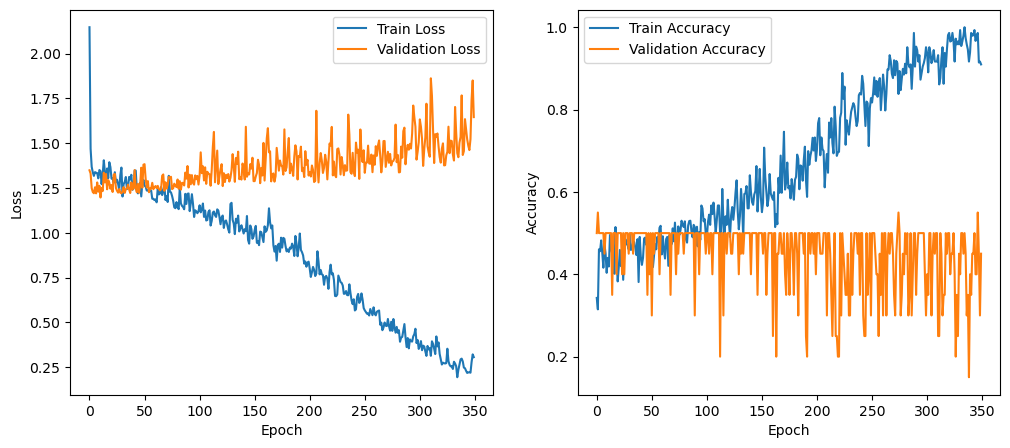

Max Valid Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▂▁▁▂▂▂▂▂▃▃▃▂▃▃▃▄▃▃▃▅▃▄▅▅▆▇▆▆▅▆▇▇▇██▇███▇
Train Loss,█▇█▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▅▅▆▅▅▄▄▄▃▄▃▂▂▂▂▂▂▁▁▁▁
Validation Accuracy,█████████▇█▇█▂▇██▇██▄██▇███▄▅▅██▂▇▂▁█▄▇▇
Validation Loss,▁▁▁▁▂▃▁▁▂▁▂▂▂▃▂▄▂▂▂▂▃▄▂▃▃▂▂▄▄▃▅▃▄▅▅█▃▄▄█
Max Valid Accuracy,0.55
Train Accuracy,0.90972
Train Loss,0.30641
Validation Accuracy,0.45
Validation Loss,1.64589


In [15]:
# Example model

threshold = 0.5
age = False
sex = False
method = 'fourier_cluster'
weight = False

hg_data_path = f'Hypergraphs/{method}/thresh_{threshold}'
root = f'Raw_to_hypergraph/ADNI_T_{threshold}_M_{method}_W{weight}_A{age}_S{sex}_MPTrue'
dataset = f.Raw_to_Hypergraph(root=root, hg_data_path=hg_data_path, method=method, weight=weight, threshold=threshold, age=age, sex=sex)

train_loader, valid_loader, test_loader, nbr_classes, y_train = f.create_train_test_valid(dataset)

# Defining the model, optimizer and loss function
lr=0.0001
hidden_channels=64
num_layers=2
dropout=0.1
heads=2
w_decay = 0
parameters = [lr, hidden_channels, num_layers, dropout, heads]
in_channels = dataset.num_features

model = HGAT(in_channels=in_channels, hidden_channels=parameters[1], out_channels=nbr_classes, num_layers=parameters[2], dropout=parameters[3], heads=parameters[4], nbr_classes=nbr_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=parameters[0], weight_decay=w_decay)
criterion = torch.nn.CrossEntropyLoss()

# Printing the model architecture
print(model)

# Running the training
train_losses, train_accuracies, valid_losses, valid_accuracies, max_valid_accuracy = train(model, optimizer, criterion, w_decay, threshold, method, train_loader, valid_loader, parameters, n_epochs=350)

In [ ]:
## A CHANGER POUR QU'IL Y AIT LE HEADS PARAMETER

# # Doing some parameter gridsearch to find the best hyperparameters
# from sklearn.model_selection import ParameterGrid

# # Building the graphs
# threshold = 0.5
# age = False
# sex = False
# method = 'fourier_cluster'
# weight = False

# hg_data_path = f'Hypergraphs/{method}/thresh_{threshold}'
# root = f'Raw_to_hypergraph/ADNI_T_{threshold}_M_{method}_W{weight}_A{age}_S{sex}_MPTrue'
# dataset = f.Raw_to_Hypergraph(root=root, hg_data_path=hg_data_path, method=method, weight=weight, threshold=threshold, age=age, sex=sex)

# # Creating the train, validation and test sets
# train_loader, valid_loader, test_loader, nbr_classes, y_train = f.create_train_test_valid(dataset, stratify)

# # param_grid = {
# #     'learning_rate': [0.001, 0.0001],
# #     'hidden_channels': [128, 64, 32],
# #     'num_layers': [3, 2, 1],
# #     'dropout_rate': [0.2, 0.1, 0.0],
# #     'weight_decay': [0.001, 0.0001]
# # }
# param_grid = {
#     'learning_rate': [0.0001, 0.001],
#     'hidden_channels': [64, 128],
#     'num_layers': [1, 2, 3],
#     'dropout_rate': [0.0, 0.1, 0.2],
#     'weight_decay': [0.0001, 0.001]
# }

# # Create combinations of hyperparameters
# param_combinations = ParameterGrid(param_grid)
# n_epochs = 800
# in_channels = dataset.num_features
# # Train using each combination
# for params in param_combinations:
#     filename = f'HGAT_Models_MP/threshold_{threshold}/method_{method}/lr{params["learning_rate"]}_hc{params["hidden_channels"]}_nl{params["num_layers"]}_d{params["dropout_rate"]}_epochs{n_epochs}_wdecay{params["weight_decay"]}_w{weight}.png'
#     if os.path.exists(filename):
#         pass
#     else:
#         parameters = [params['learning_rate'], params['hidden_channels'], params['num_layers'], params['dropout_rate']]
#         model = HGAT(in_channels=in_channels, hidden_channels=parameters[1], out_channels=nbr_classes, num_layers=parameters[2], dropout=parameters[3], nbr_classes=nbr_classes)
#         if stratify:
#             diag_lab = [0 , 1 , 2, 3]
#             class_freq = []
#             for i in diag_lab:
#                 class_freq.append(np.count_nonzero(torch.Tensor(y_train) == i))
#             class_freq = torch.FloatTensor(class_freq)
#             class_weights = 1 / class_freq
#             class_weights /= class_weights.sum()
#             criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
#         else:
#             criterion = torch.nn.CrossEntropyLoss() 
#         if 'weight_decay' not in params.keys():
#             w_decay = 0
#         else:
#             w_decay = params['weight_decay']
#         optimizer = torch.optim.Adam(model.parameters(), lr=parameters[0], weight_decay=w_decay)
#         train_losses, train_accuracies, valid_losses, valid_accuracies, max_valid_accuracy, test_accuracy = train(model, optimizer, criterion, w_decay, threshold, method, train_loader, valid_loader, parameters, test_loader, testing=True, n_epochs=800)